<a href="https://colab.research.google.com/github/pashupati98/CatText/blob/master/LSTM/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
url_rdf = '/content/drive/My Drive/IBM/dataset/raw_df.csv'
url_pdf = '/content/drive/My Drive/IBM/dataset/processed.csv'
url_udf = '/content/drive/My Drive/IBM/dataset/processed_user.csv'
url_olid = '/content/drive/My Drive/IBM/dataset/olid.csv'
url_hate = '/content/drive/My Drive/IBM/dataset/hate.csv'
rdf = pd.read_csv(url_rdf)
pdf = pd.read_csv(url_pdf)
udf = pd.read_csv(url_udf)
olid = pd.read_csv(url_olid)
hate = pd.read_csv(url_hate)

In [5]:
rdf.head()

,Unnamed: 0,tweet,label
0,0,@USER She should ask a few native Americans wh...,1
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,2,Amazon is investigating Chinese employees who ...,0
3,3,"@USER Someone should'veTaken"" this piece of sh...",1
4,4,@USER @USER Obama wanted liberals &amp; illega...,0


In [6]:
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

Using TensorFlow backend.


In [0]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("/content/drive/My Drive/IBM/Glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [0]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
    model.add(LSTM(lstm_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [0]:
def experiment(df):
  print("Running Experiment ... ")
  X = df.tweet
  y = df.label
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  print("Generating Glove ...")
  X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
  with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=1)
    warnings.simplefilter("ignore")
  print("\n Plotting results ... \n")
  plot_graphs(history, 'acc')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_RNN.predict_classes(X_test_Glove)
  #print(predicted)
  print(metrics.classification_report(y_test, predicted))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, predicted)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))

In [0]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

### Experiment with RDF

In [0]:
srdf = shuffle(rdf)

Running Experiment ... 
Generating Glove ...
Found 47632 unique tokens.
(36593, 500)
Total 400000 word vectors.
Building Model ...



32



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           2381650   
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 32)           10624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)          

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 29274 samples, validate on 7319 samples
Epoch 1/10
29274/29274 [==============================] - 717s 24ms/step - loss: 0.4782 - acc: 0.7669 - val_loss: 0.3517 - val_acc: 0.8421
Epoch 2/10
29274/29274 [==============================] - 711s 24ms/step - loss: 0.3219 - acc: 0.8590 - val_loss: 0.2778 - val_acc: 0.8802
Epoch 3/10
29274/29274 [==============================] - 711s 24ms/step - loss: 0.2628 - acc: 0.8923 - val_loss: 0.2589 - val_acc: 0.8886
Epoch 4/10
29274/29274 [==============================] - 697s 24ms/step - loss: 0.2182 - acc: 0.9123 - val_loss: 0.2576 - val_acc: 0.8903
Epoch 5/10
29274/29274 [==============================] - 694s 24ms/step - loss: 0.1771 - acc: 0.9343 - val_loss: 0.2950 - val_acc: 0.8825
Epoch 6/10
29274/29274 [==============================] - 693s 24ms/step - loss: 0.1391 - acc: 0.9496 - val_loss: 0.3169 - val_acc: 0.8845
Epoch 7/10
29274/29274 [==============================] - 699s 24ms/step - loss: 0.1059 - acc: 0.9632 - val_loss: 0.3

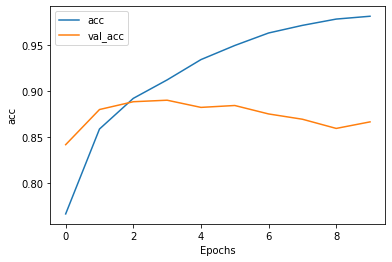

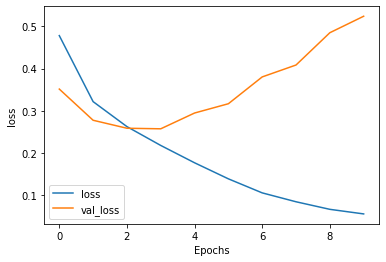


 Evaluating Model ... 



INFO:logger:  mcc = 0.7115905281384265
INFO:logger:  tp = 4183
INFO:logger:  tn = 2161
INFO:logger:  fp = 503
INFO:logger:  fn = 472
INFO:logger:  pricision = 0.8926589842082799
INFO:logger:  recall = 0.8986036519871107
INFO:logger:  F1 = 0.8956214538058024
INFO:logger:  accuracy = 0.866785079928952


              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2664
           1       0.89      0.90      0.90      4655

    accuracy                           0.87      7319
   macro avg       0.86      0.85      0.86      7319
weighted avg       0.87      0.87      0.87      7319





In [14]:
experiment(srdf)

In [0]:
spdf = shuffle(pdf)

Running Experiment ... 
Generating Glove ...
Found 45504 unique tokens.
(36593, 500)
Total 400000 word vectors.
Building Model ...
32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 50)           2275250   
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 32)           10624     
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 500, 32)        

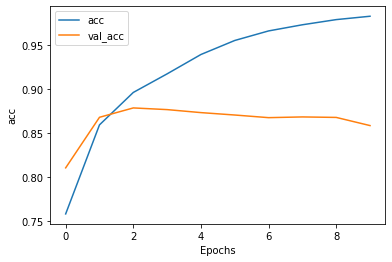

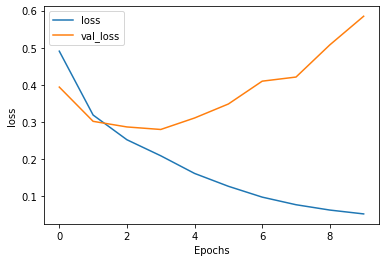


 Evaluating Model ... 



INFO:logger:  mcc = 0.6889817671003855
INFO:logger:  tp = 4257
INFO:logger:  tn = 2029
INFO:logger:  fp = 541
INFO:logger:  fn = 492
INFO:logger:  pricision = 0.8872446852855357
INFO:logger:  recall = 0.8963992419456728
INFO:logger:  F1 = 0.8917984707237877
INFO:logger:  accuracy = 0.8588605000683154


              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2570
           1       0.89      0.90      0.89      4749

    accuracy                           0.86      7319
   macro avg       0.85      0.84      0.84      7319
weighted avg       0.86      0.86      0.86      7319





In [16]:
experiment(spdf)